In [2]:
from torchvision.ops import box_iou
import os
import pandas as pd
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
BASE_DIR = "/mnt/Enterprise/safal/AI_assisted_microscopy_system/"
sample_types = ["smartphone_sample", "smartphone_reference", "brightfield_sample", "brightfield_reference"]
model_type = "retinanet"

In [467]:
def calculate_precision_recall_f1(pred_annotations_file, gt_annotations_file):
    # Precision x Recall is obtained individually by each class
    # Loop through each class and calculate the precision and recall

    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    gt_annotations = json.load(open(gt_annotations_file))
    pred_annotations = json.load(open(pred_annotations_file))

    gt_annotations_df = pd.DataFrame(gt_annotations["annotations"])
    pred_annotations_df = pd.DataFrame(pred_annotations)

    # change bbox width and height to x2, y2
    pred_annotations_df["bbox"] = pred_annotations_df["bbox"].apply(
        lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]]
    )
    gt_annotations_df["bbox"] = gt_annotations_df["bbox"].apply(
        lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]]
    )

    categories = sorted(gt_annotations_df.category_id.unique())

    # dataframe to store the precision, recall and f1 score for each class
    metrics_df = pd.DataFrame(
        columns=["category", "precision", "recall", "f1_score", "TP", "FP"]
    )

    precisions = dict((category, []) for category in categories)
    recalls = dict((category, []) for category in categories)
    confidence_scores = dict((category, []) for category in categories)

    for category in categories:
        # get the ground truth annotations for the current class
        gt_annotations_df_class = gt_annotations_df[
            gt_annotations_df.category_id == category
        ]
        # get the predicted annotations for the current class
        pred_annotations_df_class = pred_annotations_df[
            pred_annotations_df.category_id == category
        ]

        # sort the predicted annotations by score
        pred_annotations_df_class = pred_annotations_df_class.sort_values(
            by="score", ascending=False
        )

        # filter predictions with score > 0.3
        # pred_annotations_df_class = pred_annotations_df_class[
        #     pred_annotations_df_class.score > 0.5
        # ]

        true_positives_class = 0
        false_positives_class = 0

        # get image ids for the current class from both ground truth and predicted annotations
        image_ids = pred_annotations_df_class["image_id"].unique()
        images_len = len(image_ids)

        for image in image_ids:
            # get the ground truth annotations for the current image
            gt_annotations_df_image = gt_annotations_df_class[
                gt_annotations_df_class.image_id == image
            ]
            # get the predicted annotations for the current image
            pred_annotations_df_image = pred_annotations_df_class[
                pred_annotations_df_class.image_id == image
            ]

            # get the ground truth bounding boxes
            gt_bboxes = list(gt_annotations_df_image.bbox.values)
            gt_bboxes = torch.tensor(gt_bboxes)

            # get the predicted bounding boxes
            pred_bboxes = list(pred_annotations_df_image.bbox.values)
            pred_bboxes = torch.tensor(pred_bboxes)

            # get the confidence scores
            confidence_scores[category].extend(
                list(pred_annotations_df_image.score.values)
            )
            if len(gt_bboxes) == 0:
                false_positives_class += len(pred_bboxes)
                precisions[category].append(
                    true_positives_class
                    / (true_positives_class + false_positives_class)
                )
                recalls[category].append(
                    true_positives_class / gt_annotations_df_class.shape[0]
                )
                continue

            # get the intersection over union for each predicted bounding box
            ious = box_iou(pred_bboxes, gt_bboxes)

            # get the maximum iou for each ground truth bounding box
            max_ious, _ = torch.max(ious, dim=0)

            # get the indices of the predicted bounding boxes with iou > 0.5
            tp_indices = torch.where(max_ious >= 0.5)[0]
            # print(ious)

            # get the indices of the predicted bounding boxes with iou < 0.5
            fp_indices = torch.where(max_ious < 0.5)[0]

            # update the true positives and false positives
            true_positives_class += len(tp_indices)
            false_positives_class += len(fp_indices)
            precisions[category].append(
                true_positives_class / (true_positives_class + false_positives_class)
            )
            recalls[category].append(
                true_positives_class / gt_annotations_df_class.shape[0]
            )

        # calculate the precision and recall
        precision = true_positives_class / (
            true_positives_class + false_positives_class
        )
        recall = true_positives_class / gt_annotations_df_class.shape[0]

        category_name = gt_annotations["categories"][category]["name"]
        f1_score = 2 * (precision * recall) / (precision + recall)

        category_metrics_df = pd.DataFrame(
            {
                "category": category_name,
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score,
                "TP": true_positives_class,
                "FP": false_positives_class,
            },
            index=[0],
        )

        # concatenate the metrics for the current class to the metrics dataframe
        metrics_df = pd.concat([metrics_df, category_metrics_df], axis=0)

    return metrics_df, precisions, recalls, confidence_scores


## Combine metrics from all folds into a single csv

In [ ]:
# combine metrics from all folds into single csv with mean and variance
for sample_type in sample_types:
    metrics_df_all = None
    for fold in range(1, 6):
        gt_annotation_file = os.path.join(
            BASE_DIR,
            f"cysts_dataset_all/{sample_type}/fold_{fold}/{sample_type}_coco_annos_val.json",
        )

        pred_annotation_file = os.path.join(
            BASE_DIR,
            f"outputs/{sample_type}/{model_type}/fold_{fold}/results.bbox.json"
        )
        if not os.path.exists(pred_annotation_file):
            continue

        metrics_file = os.path.join(
            BASE_DIR,
            f"outputs/{sample_type}/{model_type}/fold_{fold}/metrics_pr.csv"
        )
        metrics_df = calculate_precision_recall_f1(pred_annotation_file, gt_annotation_file)
        
        if fold == 1:
            metrics_df_all = metrics_df
        else:
            metrics_df_all = pd.concat([metrics_df_all, metrics_df], ignore_index=True)
    
    # calculate class wise mean and standard deviation
    metrics_df_all = metrics_df_all.groupby("category").agg(
        {
            "precision": ["mean", "std"],
            "recall": ["mean", "std"],
            "f1_score": ["mean", "std"],
        }
    )
    metrics_df_all.columns = ["_".join(x) for x in metrics_df_all.columns]
    metrics_df_all = metrics_df_all.reset_index()
    # metrics_df_all.to_csv(
    #     os.path.join(BASE_DIR, f"outputs/{sample_type}/{model_type}/metrics_pr.csv"),
    #     index=False,
    #     float_format="%.3f",
    # )
    print("sample_type: ", sample_type)
    print(metrics_df_all)




## Plotting PR Curve

In [469]:
sample_type = "brightfield_sample"
metrics_df_all = None
precisions_giardia_all = None
recalls_giardia_all = None
precisions_crypto_all = None
recalls_crypto_all = None
confidence_scores_giardia_all = None
confidence_scores_crypto_all = None


In [470]:
for fold in range(1, 6):
    gt_annotation_file = os.path.join(
        BASE_DIR,
        f"cysts_dataset_all/{sample_type}/fold_{fold}/{sample_type}_coco_annos_val.json",
    )

    pred_annotation_file = os.path.join(
        BASE_DIR,
        f"outputs/{sample_type}/{model_type}/fold_{fold}/results.bbox.json"
    )
    if not os.path.exists(pred_annotation_file):
        continue
    metrics_df, precisions, recalls, confidence_scores = calculate_precision_recall_f1(pred_annotation_file, gt_annotation_file)

    crypto_prec_df = pd.DataFrame(precisions[0])
    crypto_rec_df = pd.DataFrame(recalls[0])
    crypto_conf_df = pd.DataFrame(confidence_scores[0])
    crypto_prec_df.columns = [f"precision"]
    crypto_rec_df.columns = [f"recall"]
    crypto_conf_df.columns = [f"confidence"]

    giardia_prec_df = pd.DataFrame(precisions[1])
    giardia_rec_df = pd.DataFrame(recalls[1])
    giardia_conf_df = pd.DataFrame(confidence_scores[1])
    giardia_prec_df.columns = [f"precision"]
    giardia_rec_df.columns = [f"recall"]
    giardia_conf_df.columns = [f"confidence"]

    precisions_giardia_all = pd.concat([precisions_giardia_all, giardia_prec_df])
    recalls_giardia_all = pd.concat([recalls_giardia_all, giardia_rec_df])
    precisions_crypto_all = pd.concat([precisions_crypto_all, crypto_prec_df])
    recalls_crypto_all = pd.concat([recalls_crypto_all, crypto_rec_df])
    confidence_scores_giardia_all = pd.concat([confidence_scores_giardia_all, giardia_conf_df])
    confidence_scores_crypto_all = pd.concat([confidence_scores_crypto_all, crypto_conf_df])




,precision
0,1.000000
1,1.000000
2,1.000000
3,1.000000
4,1.000000
...,...
194,0.415301
195,0.411924
196,0.407507
197,0.404255


In [460]:
# combine precisions for giardia with same indexes
precisions_giardia_all = precisions_giardia_all.groupby(precisions_giardia_all.index).mean()
recalls_giardia_all = recalls_giardia_all.groupby(recalls_giardia_all.index).mean()
precisions_crypto_all = precisions_crypto_all.groupby(precisions_crypto_all.index).mean()
recalls_crypto_all = recalls_crypto_all.groupby(recalls_crypto_all.index).mean()

<AxesSubplot: ylabel='precision'>

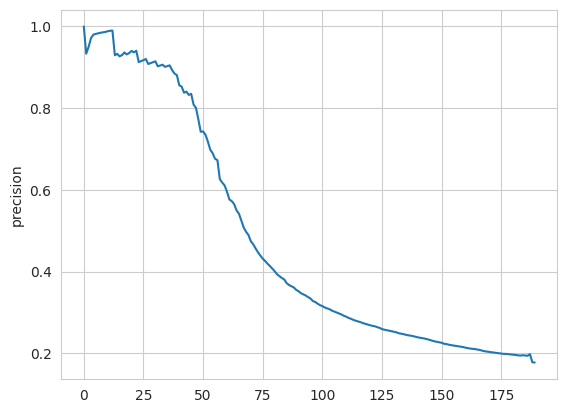

In [461]:
sns.lineplot(data=precisions_giardia_all, x=precisions_giardia_all.index, y="precision")

In [462]:
# plot giardia and crypto pr curves for the given sample type
giardia_metrics_df = pd.DataFrame(
    {
        "precision": precisions_giardia_all["precision"],
        "recall": recalls_giardia_all["recall"],
    }
)

crypto_metrics_df = pd.DataFrame(
    {
        "precision": precisions_crypto_all["precision"],
        "recall": recalls_crypto_all["recall"],
    }
)

In [464]:
# calculate f1 score
giardia_metrics_df["f1_score"] = (
    2 * giardia_metrics_df["precision"] * giardia_metrics_df["recall"]
) / (giardia_metrics_df["precision"] + giardia_metrics_df["recall"])

crypto_metrics_df["f1_score"] = (
    2 * crypto_metrics_df["precision"] * crypto_metrics_df["recall"]
) / (crypto_metrics_df["precision"] + crypto_metrics_df["recall"])


In [465]:
# get index for the best f1 score
giardia_best_f1_index = giardia_metrics_df["f1_score"].idxmax()
crypto_best_f1_index = crypto_metrics_df["f1_score"].idxmax()

In [476]:
crypto_best_f1_index

100

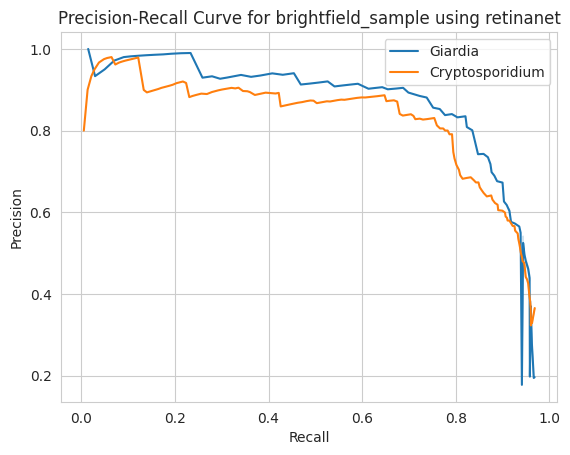

In [463]:
# plot giardia and crypto pr curves for the given sample type
sns.lineplot(data=giardia_metrics_df, x="recall", y="precision", label="Giardia")
sns.lineplot(data=crypto_metrics_df, x="recall", y="precision", label="Cryptosporidium")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve for {sample_type} using {model_type}")
plt.savefig(
    os.path.join(
        BASE_DIR,
        f"outputs/{sample_type}/{model_type}/pr_curve.png",
    ),
    dpi=300,
    bbox_inches="tight",
)